<a href="https://colab.research.google.com/github/cabamarcos/P1-RRNN/blob/main/P1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

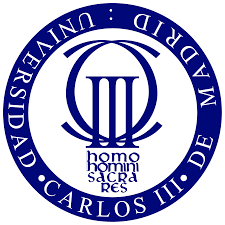

# PRÁCTICA 1: REDES DE NEURONAS
Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451247


#PREGUNTAS PROFE


*   La normalización debe ser de todo el conjunto de datos incluida la variable de respuesta (y) o solo de X????

* Si es solo de X, que habría que desnormalizar?? (en una clase dijiste que habría que desnormalizar) La salida en cada iteración del adaline?

* Repasar implementación adaline--> para actualizar los pesos calculamos en cada época cual sería el nuevo valor de los pesos para cada entrada y luego cogemos la media para actualizarlo.

* resultados del MSE de perceptron con RELU y sigmoide --> puede ser debido a algo relacionado con la normalización de los datos?







## 1. Introducción
El propósito de esta práctica es abordar un problema real de regresión utilizando dos modelos de redes de neuronas supervisados:

*   El modelo lineal Adaline.
*   El modelo no-lineal Perceptrón Multicapa.

Para ello, se nos dispone de un conjunto de datos relacionados con medidas realizadas en una turbina de gas a lo largo de 4 años. Debemos predecir el rendimiento energético de la turbina, mostrado en el campo TEY, haciendo uso del resto de mediciones de sensores.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [1]:
import random
import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

Leemos los conjuntos de datos, correspondientes a las medidas de 1 solo año, y los juntamos en un mismo dataframe de pandas.

In [2]:
archivos_csv = ['gt_2011.csv', 'gt_2012.csv', 'gt_2013.csv', 'gt_2014.csv', 'gt_2015.csv']

datos = pd.DataFrame()

# Concatenamos todos los archivos en un mismo dataframe
for archivo in archivos_csv:
    # Leemos el archivo
    df_temporal = pd.read_csv(archivo)
    # Concatenamos el archivo en el dataframe final
    datos = pd.concat([datos, df_temporal], ignore_index=True)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [3]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      36733 non-null  float64
 1   AP      36733 non-null  float64
 2   AH      36733 non-null  float64
 3   AFDP    36733 non-null  float64
 4   GTEP    36733 non-null  float64
 5   TIT     36733 non-null  float64
 6   TAT     36733 non-null  float64
 7   TEY     36733 non-null  float64
 8   CDP     36733 non-null  float64
 9   CO      36733 non-null  float64
 10  NOX     36733 non-null  float64
dtypes: float64(11)
memory usage: 3.1 MB


El conjunto de datos se compone de 36733 instancias y 11 atributos de tipo float64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [4]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


### 3.3 Correlación entre atributos
En este apartado, vamos a estudiar la correlación entre los atributos de los datos disponibles. Nos interesa conocer el par de atributos que tienen una correlación especialmente alta (> 0.95) entre ellos para así poder determinar cuáles aportan a la variable de respuesta una información extremadamente similar que su pareja. En esta situación, podríamos plantearnos descartar uno de ellos para reducir la dimensionalidad del problema.

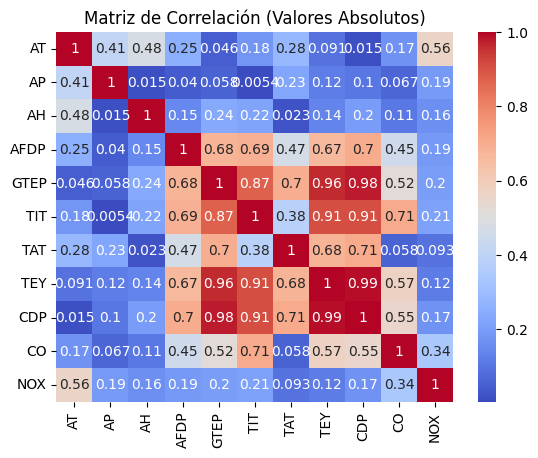

In [5]:
matriz_correlacion = datos.corr().abs()
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación (Valores Absolutos)')
plt.show()

Como vemos, TEY está muy correlacionada con CDP y GTEP; y CDP está muy correlacionada con GTEP. Como podemos observar, las tres columnas están muy correlacionadas, por lo que al ser TEY nuestra columna objetivo, no podemos suprimir datos que están tan correlacionados con la solución, ya que supondría empeorar las predicciones.

TAMBIÉN OBSERVAMOS QUE GTEP Y CDP ESTÁN ALTAMENTE CORRELACIONADAS ENTRE SÍ. ADEMÁS, FIJÁNDONOS EN AMBAS COLUMNAS EN LA MATRIZ DE CORRELACIÓN, PODEMOS OBSERVAR QUE LOS VALORES SON BASTANTE SIMILARES Y LA CORRELACIÓN CON LAS DEMÁS ES BASTANTE PARECIDA. ESTO NOS HACE PENSAR QUE PODEMOS ELIMINAR UNA DE ESTAS COLUMNAS
¡¡¡¡¡¡....... REDACTAR MEJOR........!!!!!

## 4. División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn. Dividimos los datos en un 70% para train, un 15% para test, y un 15% para validation tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [6]:
X = datos.drop("TEY", axis = 1)
y = datos["TEY"]
X

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,11.910,0.26747,82.028
...,...,...,...,...,...,...,...,...,...,...
36728,3.6268,1028.5,93.200,3.1661,19.087,1037.0,541.59,10.411,10.99300,89.172
36729,4.1674,1028.6,94.036,3.1923,19.016,1037.6,542.28,10.344,11.14400,88.849
36730,5.4820,1028.5,95.219,3.3128,18.857,1038.0,543.48,10.462,11.41400,96.147
36731,5.8837,1028.7,94.200,3.9831,23.563,1076.9,550.11,11.771,3.31340,64.738


Dividimos el conjunto de datos. Lo hacemos especificando el parámetro random_state a 42 para que se aleatorizen los datos y el resultado sea reproducible.


In [7]:
# Dividir los datos originales en conjuntos de entrenamiento (70%) y test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividir el conjunto de prueba en conjuntos de validación (15%) y test (15%)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_validation

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
9060,17.1960,995.96,83.276,4.1779,20.454,1057.9,549.36,10.587,3.0602,73.598
33780,29.7170,1010.30,57.389,4.4296,30.199,1099.9,544.72,13.204,0.9261,53.272
7555,13.1260,999.57,84.483,4.1593,24.254,1084.3,550.15,11.873,1.6692,74.223
36051,20.5170,1017.70,64.559,4.2873,30.931,1100.0,540.34,13.515,1.7370,51.516
8023,8.9965,1025.00,83.895,5.7124,32.828,1100.1,529.53,13.879,0.4909,63.462
...,...,...,...,...,...,...,...,...,...,...
27760,17.4740,1019.90,89.325,3.9248,22.169,1065.0,550.01,11.197,3.1294,61.156
13160,23.6420,1013.50,83.250,4.4636,25.764,1092.3,550.01,12.127,1.5099,64.478
15718,4.8652,1013.60,91.351,2.9773,23.396,1081.9,550.03,11.720,1.6524,83.076
10968,29.9860,1009.30,57.941,4.2750,26.176,1092.9,549.64,12.216,1.5581,62.199


## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las tranformaciones de datos que realizamos son las siguientes:

### 5.1 Normalización

Para que no se produzca information leakage, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [8]:
max_min = {}
for columna in X_train:
  min = X_train[columna].min()
  max = X_train[columna].max()
  # Guardamos el valor maximo y minimo de cada columna para después poder desnormalizar
  max_min[columna] = {'min': min, 'max': max}
  # Conjunto de entrenamiento
  X_train[columna] = (X_train[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test[columna] - min)/(max - min)

X_validation

,AT,AP,AH,AFDP,GTEP,TIT,TAT,CDP,CO,NOX
9060,0.557123,0.192850,0.771954,0.382350,0.119732,0.570430,0.968410,0.134681,0.069354,0.507345
33780,0.854839,0.477656,0.423133,0.428386,0.543097,0.990010,0.851150,0.629987,0.020963,0.291123
7555,0.460349,0.264548,0.788218,0.378948,0.284821,0.834166,0.988375,0.378076,0.037813,0.513994
36051,0.636087,0.624628,0.519747,0.402359,0.574898,0.991009,0.740460,0.688849,0.039350,0.272443
8023,0.362160,0.769613,0.780295,0.663009,0.657312,0.992008,0.467273,0.757741,0.011095,0.399521
...,...,...,...,...,...,...,...,...,...,...
27760,0.563733,0.668322,0.853462,0.336059,0.194239,0.641359,0.984837,0.250132,0.070923,0.374991
13160,0.710392,0.541212,0.771603,0.434604,0.350421,0.914086,0.984837,0.426149,0.034201,0.410329
15718,0.263929,0.543198,0.880762,0.162762,0.247545,0.810190,0.985342,0.349118,0.037432,0.608170
10968,0.861235,0.457795,0.430571,0.400110,0.368320,0.920080,0.975486,0.442993,0.035294,0.386086


### 5.2 Eliminación de atributos correlacionados

¡¡GTEP Y CDP!!--> eliminar uno

## 6. Implementación del modelo lineal Adaline

### 6.1 Adaline implementado con nested loops (ineficiente)

In [9]:
class Adaline_for:
    def __init__(self, learning_rate=0.1, epochs=50, random_seed = 45):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.random_seed = random_seed
        self.error_entrenamiento = []
        self.historical_weights = []

    def fit(self, X, y):
      # Inicializamos el Adaline
        self.__initialize_Adaline(X)

        # Para cada época
        for i in range(self.epochs):
          error_filas = []
          # Para cada fila
          for fila in range(X.shape[0]):
            # Calculamos la salida
            salida = self.weights * X.loc[fila]
            salida = salida.sum() + self.bias
            # Obtenemos el error
            error = y.loc[fila] - salida
            error_filas.append(error**2) # Insertamos el error al cuadrado de cada fila para luego obtener el MSE de entrenamiento
            # Actualizamos los pesos
            self.weights += self.learning_rate * error * X.loc[fila]
            # Actualizamos el umbral
            self.bias += self.learning_rate * error
          # Obtenemos el MSE y lo insertamos en la lista del error de entrenamiento
          self.error_entrenamiento.append(np.array(error_filas).mean())

    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1,1,size = n_features)
        self.bias = np.random.uniform(-1,1)

In [10]:
# Leemos el conjunto de datos de aulaglobal
datos_prueba = pd.read_csv("datosArtificiales.txt", delimiter=' ', header=None)
# Dividimos los datos en atributos (X) y salida (y)
X_prueba = datos_prueba.iloc[:,:2]
y_prueba = datos_prueba.iloc[:,-1]
# Entrenamos el modelo
modelo_prueba_for = Adaline_for(learning_rate = 0.2, epochs=50)
start_time = time.time()
modelo_prueba_for.fit(X_prueba,y_prueba)
tiempo_total = time.time() - start_time
print(modelo_prueba_for.error_entrenamiento)
print("Tiempo de entrenamiento: ", tiempo_total)

[0.012930857011201457, 4.031366008854029e-12, 5.26772923183667e-21, 1.5193705242473636e-29, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544551898e-30, 7.741157544

Observamos que el tiempo de entrenamiento es extremadamente alto para ser un modelo simple y tener únicamente 50 épocas.

Por tanto, decidimos implementar el modelo Adaline de una forma más eficiente. Para ello, utilizamos matrices (numpy arrays) en vez de utilizar un nested loop (complejidad exponencial).

### 6.2 Adaline implementado con matrices (eficiente)



In [11]:
class Adaline:
    def __init__(self, learning_rate=0.1, epochs=100, random_seed = 45):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.umbral = None
        self.random_seed = random_seed
        self.error_entrenamiento = []

    def __initialize_Adaline(self,X):
        np.random.seed(self.random_seed)
        n_samples, n_features = X.shape
        self.weights = np.random.uniform(-1, 1, size=(n_features, 1))
        self.umbral = np.random.uniform(-1,1)

    def fit(self, X, y):
        # Inicializamos el Adaline
        self.__initialize_Adaline(X)
        # Convertimos X e y a dos arrays de numpy
        X = X.values
        y = y.to_numpy().reshape(-1, 1)

        for i in range(self.epochs):
          # Obtenemos la salida
          salida = np.dot(X, self.weights) + self.umbral

          # Obtenemos los errores
          errores = y - salida

          # Actualizamos el vector de pesos
          new_weights = self.learning_rate * X * errores # Calculamos los nuevos pesos para cada entrada
          media_new_weights = np.mean(new_weights, axis=0) # Calculamos la media de los nuevos pesos
          self.weights += media_new_weights.reshape(-1, 1)

          # Actualizamos el umbral
          self.umbral += self.learning_rate * errores.mean()

          # Obtenemos y guardamos el MSE
          error_entrenamiento = mean_squared_error(salida, y)
          self.error_entrenamiento.append(error_entrenamiento)

    def predict(self, X):
      # Convertimos X a un array de numpy
      X = X.values
      salida = np.dot(X, self.weights) + self.umbral
      return salida



A continuación, comprobamos nuestra implementación del Adaline utilizando los datos artificiales proporcionados en aulaglobal. Para ello, entrenaremos varios modelos con diferentes tasas de aprendizaje y analizaremos el error de entrenamiento.

[2.158244878581515, 0.28414215584736857, 0.18058598678638343, 0.15573155829155408, 0.1368033127400094, 0.12035943738142933, 0.10596763935799346, 0.09336136539818929, 0.08231327249439994, 0.0726256141723569, 0.06412618221633133, 0.05666496551607798, 0.050111255731325015, 0.04435113331555994, 0.03928528342232312, 0.034827098198229337, 0.030901027729016328, 0.027441146891559288, 0.02438990969081674, 0.021697066414137937, 0.019318722192147905, 0.017216518381333545, 0.015356920635561022, 0.013710599661569884, 0.012251892499961642, 0.010958333775584056, 0.00981024775182525, 0.008790393230207718, 0.007883654384131711, 0.007076771524756893, 0.006358106586132969, 0.005717438801671627, 0.005145786638667826, 0.004635252573778297, 0.0041788877405165206, 0.0037705738689211995, 0.003404920275402888, 0.0030771739541422738, 0.0027831410761778213, 0.002519118423577709, 0.0022818334782638682, 0.002068392051982347, 0.0018762324889243284, 0.0017030855984858722, 0.0015469395851194757, 0.0014060093373534437

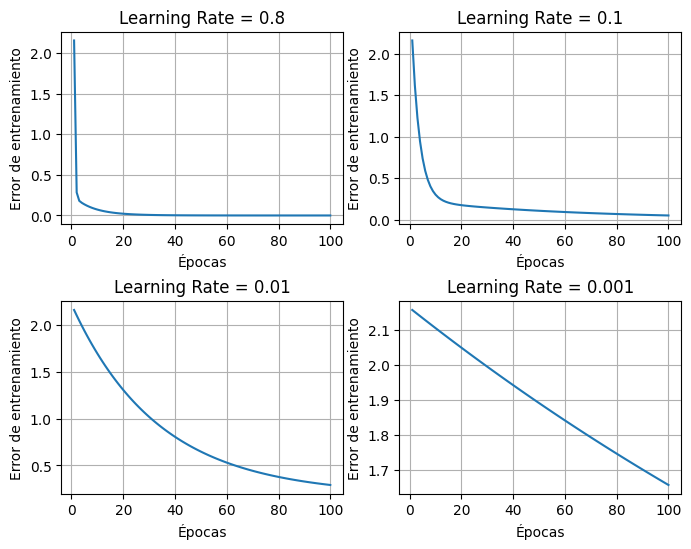

Tiempo de entrenamiento para learning rate 0.8 = 0.02494192123413086 segundos
Tiempo de entrenamiento para learning rate 0.1 = 0.025681734085083008 segundos
Tiempo de entrenamiento para learning rate 0.01 = 0.028720378875732422 segundos
Tiempo de entrenamiento para learning rate 0.001 = 0.030504941940307617 segundos


In [12]:
# Definimos las tasas de aprendizaje a probar
learning_rates = [0.8, 0.1, 0.01, 0.001]
epochs = 100

# Representación gráfica de la evolución del error de entrenamiento
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) # Creamos un grid de 2x2 para las gráficas
fig.subplots_adjust(hspace=0.4)

tiempo_entrenamiento = []
for i, lr in enumerate(learning_rates):
    # Entrenamos el modelo con la tasa de aprendizaje actual
    modelo_prueba = Adaline(learning_rate=lr, epochs=epochs)
    start_time = time.time()
    modelo_prueba.fit(X_prueba, y_prueba)
    tiempo_total = time.time() - start_time
    tiempo_entrenamiento.append(tiempo_total)
    # Representamos gráficamente el error de entranamiento de cada modelo con diferente tasa de aprendizaje
    ax = axs[i // 2, i % 2]
    ax.plot(range(1, len(modelo_prueba.error_entrenamiento) + 1), modelo_prueba.error_entrenamiento)
    ax.set_title(f'Learning Rate = {lr}')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('Error de entrenamiento')
    ax.grid()

    print(modelo_prueba.error_entrenamiento)

plt.show()

# Imprimimos los tiempos de entrenamiento correspondientes a cada tasa de aprendizaje
for lr, tiempo in zip(learning_rates, tiempo_entrenamiento):
    print(f"Tiempo de entrenamiento para learning rate {lr} = {tiempo} segundos")

Podemos observar que el error cuadrático medio desciende en cada época, y se va aproximando a 0, por lo que el modelo está correctamente implementado.

## 7. Elección de los mejores hiperparámetros en función del error de validación

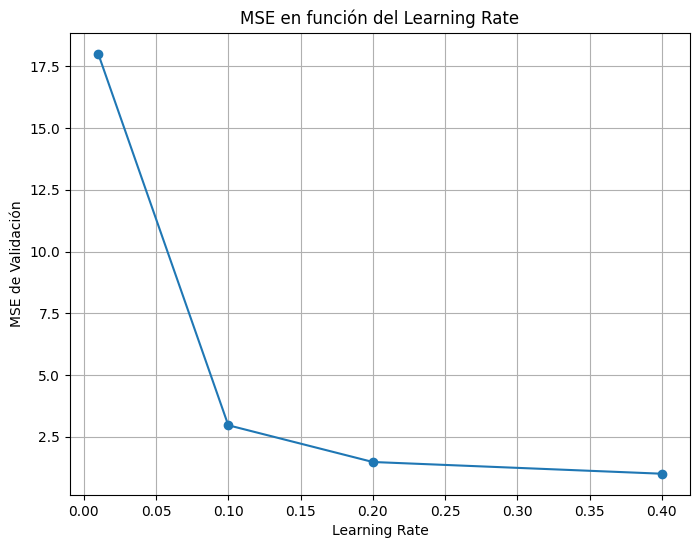

Valores del error de validación:  [0.999625784293894, 1.4747660260697961, 2.9631039081435695, 18.01345996652454]
Tiempo de entrenamiento  [8.859067440032959, 10.736959218978882, 10.20389175415039, 10.7761070728302]


In [13]:
# Lista de tasas de aprendizaje a probar
learning_rates = [0.4, 0.2, 0.1, 0.01]

# Lista para almacenar los errores RMSE de validación
mse_validation_values = []
# Lista para almacenar los tiempos de entrenamiento
tiempo_entrenamiento = []
# Entrenar el modelo con diferentes tasas de aprendizaje y calcular el RMSE
for lr in learning_rates:
    modelo = Adaline(learning_rate=lr, epochs=5000)
    start_time = time.time()
    modelo.fit(X_train, y_train)
    tiempo_total = time.time() - start_time
    tiempo_entrenamiento.append(tiempo_total)
    prediccion = modelo.predict(X_validation)
    mse_validation = mean_squared_error(y_validation, prediccion)
    mse_validation_values.append(mse_validation)

# Creamos la gráfica
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, mse_validation_values, marker='o', linestyle='-')
plt.title('MSE en función del Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('MSE de Validación')
plt.grid(True)
plt.show()

print("Valores del error de validación: ",mse_validation_values)
print("Tiempo de entrenamiento ",tiempo_entrenamiento)


learning_rate = 0.5 el error se dispara!!

Learning_rate óptimo: 0.5

Elegimos el mejor modelo y lo entrenamos con estos hiperparametros incluyendo el conjunto de validación en el conjunto de entrenamiento para probarlo con el conjunto de test.

## 8. Predicción y error de test

In [14]:
# Juntamos el conjunto de entrenamiento y el conjunto de validación en un mismo dataframe
X_train_validation = pd.concat([X_train, X_validation], ignore_index=True)
y_train_validation = pd.concat([y_train, y_validation], ignore_index=True)

# Entrenamos el modelo con los mejores hiperparámteros
modelo_test = Adaline(learning_rate=0.4, epochs=5000)
modelo_test.fit(X_train_validation, y_train_validation)

# Predecimos los datos de test
prediccion = modelo_test.predict(X_test)
# Obtenemos el MSE
mse_test = mean_squared_error(prediccion, y_test)

print(mse_test)

1.0102952446181515


## 9. Modelos de Keras

In [15]:
import tensorflow as tf

#from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense

### 9.1 Adaline

Creamos el modelo

In [16]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla , en este caso sera (21,)

#modelo lineal, solo para comparar con el programa desarrollado.
def create_lineal(): # Una sola neurona lineal (Adaline)
  model = Sequential()
  model.add(Dense(1, input_shape=input_shape, activation='linear'))
  return model

model_adaline=create_lineal() # 1 capa salida LINEAL (ADALINE)


Entrenamos el modelo

Epoch 1/50
804/804 [==============================] - 3s 2ms/step - loss: 53.3215 - mse: 53.3215 - val_loss: 4.9923 - val_mse: 4.9923
Epoch 2/50
804/804 [==============================] - 2s 2ms/step - loss: 3.5542 - mse: 3.5542 - val_loss: 2.4222 - val_mse: 2.4222
Epoch 3/50
804/804 [==============================] - 2s 2ms/step - loss: 2.0143 - mse: 2.0143 - val_loss: 1.7283 - val_mse: 1.7283
Epoch 4/50
804/804 [==============================] - 2s 2ms/step - loss: 1.5138 - mse: 1.5138 - val_loss: 1.4707 - val_mse: 1.4707
Epoch 5/50
804/804 [==============================] - 2s 3ms/step - loss: 1.2983 - mse: 1.2983 - val_loss: 1.3586 - val_mse: 1.3586
Epoch 6/50
804/804 [==============================] - 2s 3ms/step - loss: 1.1923 - mse: 1.1923 - val_loss: 1.3062 - val_mse: 1.3062
Epoch 7/50
804/804 [==============================] - 2s 2ms/step - loss: 1.1367 - mse: 1.1367 - val_loss: 1.2804 - val_mse: 1.2804
Epoch 8/50
804/804 [==============================] - 2s 2ms/step - loss: 

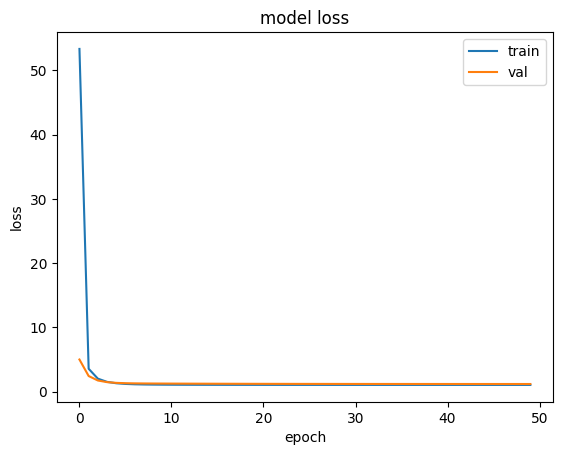

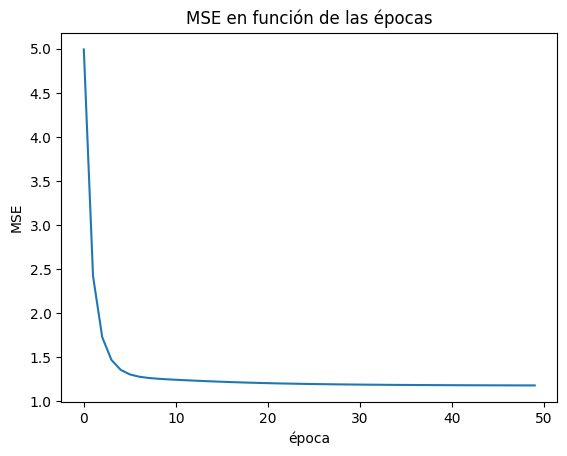

In [18]:
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.2 # razon de aprendizaje
epochs = 50 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32 # ¡¡¡¡¡¡ no cambiar este valor !!!!!!!!!!!!!!
# Para poder ver la curva de validación hay que poner validation_freq=1. Tarda más
model_adaline.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = model_adaline.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)

# Calcula RMSE
mse = historico.history['val_mse']  # Obtiene el MSE de la historia

plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plotea el RMSE
plt.plot(mse)
plt.title('MSE en función de las épocas')
plt.ylabel('MSE')
plt.xlabel('época')
plt.show()

### 9.2 Perceptrón multicapa con función de activación RELU

Creamos el modelo

In [19]:
def create_PM_relu(num_hidden_neurons = 50):
#1 capa oculta con relu y 1 neurona de salida con sigmoide
  model = Sequential()
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  return model

model_relu = create_PM_relu(20)

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.4316 - mse: 17812.4316 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 2/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 3/10
804/804 [==============================] - 2s 3ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 5/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 6/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_los

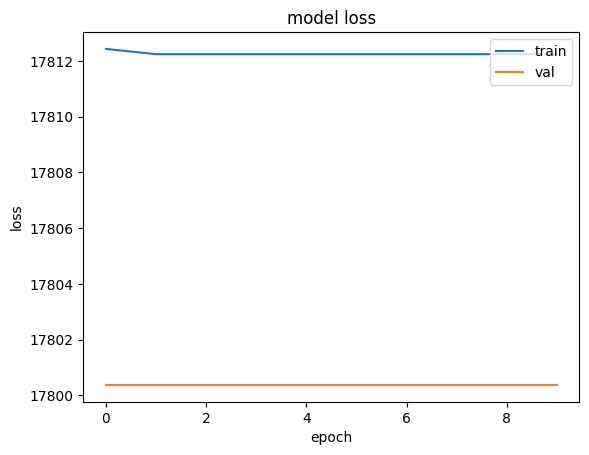

In [20]:
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.2 # razon de aprendizaje
epochs = 10 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32 # ¡¡¡¡¡¡ no cambiar este valor !!!!!!!!!!!!!!
# Para poder ver la curva de validación hay que poner validation_freq=1. Tarda más
model_relu.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = model_relu.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)


plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### 9.3 Perceptrón multicapa con función de activación sigmoide

Creamos el modelo

In [21]:
def create_PM_sigmoid(num_hidden_neurons = 50):#se pone un valor por defecto a num_hidden_neurons, pero puede llamarse con otro valor
  #1 capa oculta y 1 neurona de salida con sigmoide
  model = Sequential() # generamos el modelo dandole una forma secuencial:
  model.add(Dense(num_hidden_neurons, input_shape=input_shape, activation='sigmoid')) # capa con x=num_hidden_neurons neuronas activadas con sigmoide
  model.add(Dense(1,activation='sigmoid')) # capa con x=1 neurona (solo una neurona de salida) activada con sigmoide
  return model

model_sigmoid = create_PM_sigmoid(20)

Epoch 1/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.4805 - mse: 17812.4805 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 2/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 3/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 4/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 5/10
804/804 [==============================] - 3s 3ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 6/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_loss: 17800.3789 - val_mse: 17800.3789
Epoch 7/10
804/804 [==============================] - 2s 2ms/step - loss: 17812.2422 - mse: 17812.2422 - val_los

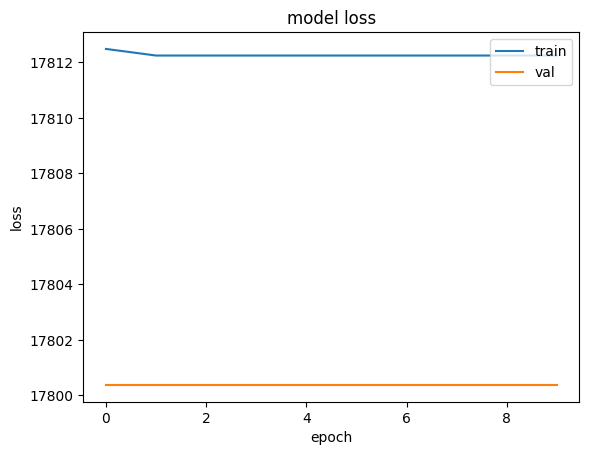

In [22]:
# CONFIGURAR MODELO Y ENTRENAMIENTO
lr = 0.2 # razon de aprendizaje
epochs = 10 # numero de ciclos que se quiere realizar en el entrenamiento
batch_size=32 # ¡¡¡¡¡¡ no cambiar este valor !!!!!!!!!!!!!!
# Para poder ver la curva de validación hay que poner validation_freq=1. Tarda más
model_sigmoid.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'] )
historico = model_sigmoid.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_validation,y_validation),
shuffle=False, validation_freq=1)


plt.plot(historico.history['loss'])
plt.plot(historico.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()